In [1]:
from langchain_groq import ChatGroq

# TODO: improve all prompts
llm = ChatGroq(model="llama-3.3-70b-specdec")

In [2]:
from typing import List

from langchain_community.document_loaders import PyPDFLoader
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field


def parse_pdf(path: str) -> str:
    docs = PyPDFLoader(path).load()
    text = " ".join(doc.page_content for doc in docs)
    return text


class Experience(BaseModel):
    """Schema for an experience entry on resume."""

    title: str = Field(description="The title of the job.")
    description: str = Field(description="A description of the job.")


class Project(BaseModel):
    """Schema for a project entry on resume."""

    title: str = Field(description="The title of the project.")
    description: str = Field(description="A description of the project.")


class Resume(BaseModel):
    """Breakdown of a resume into experiences, projects, and skills."""

    experiences: List[Experience] = Field(
        description="The experiences listed on the resume."
    )
    projects: List[Project] = Field(description="The projects listed on the resume.")
    skills: List[str] = Field(description="The skills listed on the resume.")


resume_breaker_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a resume parser. Your task is to breakdown the resume provided "
            "below into three sections: experiences, projects, and skills.",
        ),
        ("system", "<resume>\n{resume}\n</resume>"),
    ]
)
resume_breaker = resume_breaker_prompt | llm.with_structured_output(Resume)

In [3]:
# resume = resume_breaker.invoke({"resume": parse_pdf("../media/resume.pdf")})
# resume

In [4]:
class JobDescription(BaseModel):
    """Schema for a job description."""

    job_description: str = Field(description="The job description.")


job_description_parser_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a job description parser. Your task is to parse the job description "
            "from the provided text below",
        ),
        ("system", "<job_description>\n{job_description}\n</job_description>"),
    ]
)

job_description_parser = job_description_parser_prompt | llm.with_structured_output(
    JobDescription
)

In [5]:
class CodingQuestions(BaseModel):
    """Schema for a coding question."""

    questions: List[str] = Field(description="The list of technical coding questions.")


# TODO: use few shot prompts with this system prompt and differnt techstack and questions related to it.
# You can use job description as well if given in the state.
generate_coding_question_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a coding interviewer. Your task is to generate exactly 2 technical "
            "programming/coding questions based on the skills mentioned below.",
        ),
        ("system", "<skills>\n{skills}\n</skills>"),
    ]
)

generate_coding_question = generate_coding_question_prompt | llm.with_structured_output(
    CodingQuestions
)

In [6]:
# skills = ", ".join(skill for skill in resume.skills)
# coding_questions = generate_coding_question.invoke({"skills": skills})
# coding_questions

In [7]:
class CodingInterviewScore(BaseModel):
    """Schema for a coding interview score."""

    score: int = Field(description="The score of the candidate's response.")


coding_question_assessment_promt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a coding interviewer. Your task is to assess the candidate's "
            "response by a score between 1 to 10 where 1 is very bad and 10 is perfect "
            "answer. Here is the question: \n{question}",
        ),
        ("user", "{response}"),
    ]
)
coding_question_assessment = (
    coding_question_assessment_promt | llm.with_structured_output(CodingInterviewScore)
)

In [8]:
from typing import Union

from langchain_core.prompts import MessagesPlaceholder


class ExperienceInterviewScore(BaseModel):
    """Schema for an experience interview score."""

    score: int = Field(
        description=(
            "The score of the candidate's responses between 1 to 10 where 1 is "
            "extremely bad and 10 is perfect."
        )
    )


class ExperienceInterviewQuestion(BaseModel):
    """Schema for an experience interview."""

    response: Union[str, ExperienceInterviewScore] = Field(
        description=(
            "The question you want to ask. If you want to stop the conversation, "
            "provide the score to candidate's responses using the Experience "
            "Interview score schema."
        )
    )


expereince_interviewer_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are an highly experienced interviewer at a tech company and your task is to take "
            "interviews of new candidates for the provided job description (if any is provided). You "
            "can ask questions about the candidate's previous work experiences. If you think that you "
            "need to ask a follow up question, you can ask that as well or else you can move on to the "
            "next question. If you feel you have asked enough questions (5 questions are sufficient but"
            " if you feel more are necessary go for it) and think you should end the interview give the "
            "score to candidate using Experience Interview Score schema. No need to extend you conversati"
            "on. Ask only relevant questions.",
        ),
        ("system", "<job_description>\n{job_description}\n</job_description>"),
        ("system", "<experience>\n{experience}\n</experience>"),
        ("system", "<projects>\n{projects}\n</projects>"),
        # MessagesPlaceholder("messages")
    ]
)

experience_interviewer = expereince_interviewer_prompt | llm.with_structured_output(
    ExperienceInterviewQuestion
)

In [9]:
# experience_interviewer.invoke(
#     {
#         "experience": resume.experiences,
#         "projects": resume.projects,
#         "messages": []
#     }
# )

In [10]:
from langgraph.graph import MessagesState


class Interview(MessagesState):
    job_description: str
    resume: str
    experiences: List[Experience] = []
    projects: List[Project] = []
    skills: List[str] = []
    coding_questions: List[str] = None
    current_question_index: int = None
    coding_scores: List[int] = None
    coding_interview_score: int = None
    experience_interview_score: int = None

In [11]:
from langchain_core.messages import ChatMessage
from langgraph.graph import END
from langgraph.types import Command, interrupt


async def parser_node(state: Interview):
    # TODO: give llm the entire ability to parse the resume and break it down
    # in whatever parts he feels suitable and then make decisions accordingly
    resume = state["resume"]
    resume_content = resume

    job_description = state["job_description"]

    parsed_resume = await resume_breaker.ainvoke({"resume": resume_content})
    parsed_job_description = await job_description_parser.ainvoke(
        {"job_description": job_description}
    )
    return {
        "experiences": parsed_resume.experiences,
        "projects": parsed_resume.projects,
        "skills": parsed_resume.skills,
        "job_description": parsed_job_description.job_description,
    }


# TODO: implement it like the experience_interviewer_node if that works
async def coding_interviewer_node(state: Interview):
    if "coding_interview_score" not in state:
        skills = ", ".join(skill for skill in state["skills"])
        coding_questions = await generate_coding_question.ainvoke({"skills": skills})
        state["coding_questions"] = coding_questions.questions
        state["current_question_index"] = 0
        state["coding_scores"] = []
        return {
            "messages": [ChatMessage(role="ai", content=coding_questions.questions[0])]
        }

    if "current_question_index" in state:
        question = state["coding_questions"][state["current_question_index"]]
        last_message = state["messages"][-1][1]

        score = await coding_question_assessment.ainvoke(
            {"question": question, "response": last_message}
        )
        state["coding_scores"].append(score.score)

        next_index = state["current_question_index"] + 1
        if next_index < len(state["coding_questions"]):
            state["current_question_index"] = next_index
            return {
                "messages": [
                    ChatMessage(
                        role="ai", content=state["coding_questions"][next_index]
                    )
                ]
            }
        else:
            total_score = sum(state["coding_scores"]) + 10
            return {
                "coding_interview_score": total_score // len(state["coding_questions"]),
            }


async def experience_interviewer_node(state: Interview):
    response = await experience_interviewer.ainvoke(
        {
            "job_description": state["job_description"],
            "experience": state["experiences"],
            "projects": state["projects"],
            # "messages": state["messages"],
        }
    )
    if isinstance(response, ExperienceInterviewScore):
        return {"experience_interview_score": response.score}
    return {"messages": [("ai", response.response)]}


def candidate_node(state: Interview):
    answer = interrupt("")
    return {"messages": [ChatMessage(role="human", content=answer)]}


def should_end_coding(state: Interview):
    if "coding_interview_score" in state and state["coding_interview_score"]:
        return "experience_interviewer_node"
    else:
        return "candidate_node"


def should_end_experience(state: Interview):
    if "experience_interview_score" in state and state["experience_interview_score"]:
        return END
    else:
        return "candidate_node"


def should_go_to_coding(state: Interview):
    if "coding_interview_score" in state and state["coding_interview_score"]:
        return "experience_interviewer_node"
    else:
        return "coding_interviewer_node"

In [12]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import START, StateGraph

workflow = StateGraph(Interview)

workflow.add_node("parser_node", parser_node)
workflow.add_node("coding_interviewer_node", coding_interviewer_node)
workflow.add_node("experience_interviewer_node", experience_interviewer_node)
workflow.add_node("candidate_node", candidate_node)

workflow.add_edge(START, "parser_node")
workflow.add_edge("parser_node", "coding_interviewer_node")

workflow.add_conditional_edges(
    "coding_interviewer_node",
    should_end_coding,
    ["candidate_node", "experience_interviewer_node"],
)

workflow.add_conditional_edges(
    "experience_interviewer_node", should_end_experience, ["candidate_node", END]
)

workflow.add_conditional_edges(
    "candidate_node",
    should_go_to_coding,
    ["coding_interviewer_node", "experience_interviewer_node"],
)

graph = workflow.compile(checkpointer=MemorySaver())

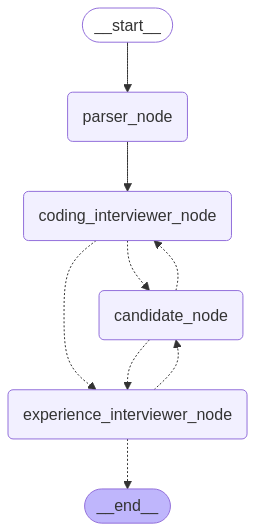

In [13]:
from IPython.display import Image, display

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [14]:
config = {"configurable": {"thread_id": "aayush1"}}

async for update in graph.astream(
    {
        "job_description": """
Required Skills & Qualifications:
• Experience between 3-6 yrs in AI/ML development, with hands-on experience in Llama, OpenAI (GPT models), and Falcon.
• Strong programming skills in Python, with experience in TensorFlow, PyTorch, or Hugging Face Transformers.
• Proficiency in API development and integration with AI models.
• Experience in fine-tuning large language models (LLMs) for various applications.
• Knowledge of cloud platforms (AWS, GCP, or Azure) for AI model deployment.
• Hands-on experience with NLP techniques, embeddings, and tokenization.
• Strong understanding of vector databases (e.g., Pinecone, FAISS) for efficient AI retrieval tasks.
• Experience in optimizing AI models for speed, accuracy, and scalability.
• Familiarity with Docker and Kubernetes for deploying AI applications.
• Strong problem-solving skills and ability to work in an agile development environment..

""",
        "resume": parse_pdf("../media/resume.pdf"),
    },
    config=config,
):
    print(update)
    print(
        "----------------------------------------------------------------------------------------------------------------"
    )

{'parser_node': {'experiences': [Experience(title='Machine Learning Intern', description='Research and develop AI-driven machine learning models for climate solutions, including predictive analytics for environmental monitoring. Assist in data collection, preprocessing, and augmentation for climate-related datasets to enhance model accuracy. Implement AI solutions for climate impact assessment and integrate them into the Surya Sangam Web Portal. Automate climate data analysis and reporting to support sustainability initiatives.'), Experience(title='Technical Document Specialist', description='Tailored more than 200 resumes and got a score of more than 75% on Jobscan score in every resume securing clients multiple interviews. Developed Python scripts for automating the process of tailoring resumes using LLMs with advanced RAG chains. Shared useful insights to the clients about their resume and maintained open communication with them. Used prompt engineering to get consistent and relevan

In [15]:
async for event in graph.astream(
    Command(
        resume="""
import cv2 as cv
            
def resize_image(image_path, width, height):
    image = cv.imread(image_path)
    resized_image = cv.resize(image, (width, height))
    cv.imwrite(image_path, resized_image)
    return "resized successfully"
"""
    ),
    config=config,
):
    print(event)
    print(
        "----------------------------------------------------------------------------------------------------------------"
    )

{'candidate_node': {'messages': [ChatMessage(content='\nimport cv2 as cv\n\ndef resize_image(image_path, width, height):\n    image = cv.imread(image_path)\n    resized_image = cv.resize(image, (width, height))\n    cv.imwrite(image_path, resized_image)\n    return "resized successfully"\n', additional_kwargs={}, response_metadata={}, id='4b4feff1-7d74-47a2-961f-42e8a0d28ee2', role='human')]}}
----------------------------------------------------------------------------------------------------------------
{'coding_interviewer_node': {'messages': [ChatMessage(content='Write a Python program using PyTorch and Transformers to fine-tune a pre-trained language model for sentiment analysis on a given dataset.', additional_kwargs={}, response_metadata={}, id='46ca45df-b52e-45e5-af66-1c715f7f1d20', role='ai')]}}
----------------------------------------------------------------------------------------------------------------
{'__interrupt__': (Interrupt(value='', resumable=True, ns=['candidate_no

In [16]:
async for event in graph.astream(
    Command(
        resume="""
from fastapi import FastAPI, HTTPException
import requests
from bs4 import BeautifulSoup

app = FastAPI()

@app.get("/scrape/")
def scrape_website(url: str, element: str = "p"):
    try:
        headers = {"User-Agent": "Mozilla/5.0"}
        response = requests.get(url, headers=headers)
        response.raise_for_status()
    except requests.RequestException as e:
        raise HTTPException(status_code=400, detail=str(e))
    
    # Parse the HTML content
    soup = BeautifulSoup(response.text, "html.parser")
    extracted_texts = [tag.get_text(strip=True) for tag in soup.find_all(element)]
    
    return {"extracted_data": extracted_texts}

# To run the FastAPI server, save this script and run:
# uvicorn script_name:app --reload

"""
    ),
    config=config,
):
    print(event)
    print(
        "----------------------------------------------------------------------------------------------------------------"
    )

{'candidate_node': {'messages': [ChatMessage(content='\nfrom fastapi import FastAPI, HTTPException\nimport requests\nfrom bs4 import BeautifulSoup\n\napp = FastAPI()\n\n@app.get("/scrape/")\ndef scrape_website(url: str, element: str = "p"):\n    try:\n        headers = {"User-Agent": "Mozilla/5.0"}\n        response = requests.get(url, headers=headers)\n        response.raise_for_status()\n    except requests.RequestException as e:\n        raise HTTPException(status_code=400, detail=str(e))\n\n    # Parse the HTML content\n    soup = BeautifulSoup(response.text, "html.parser")\n    extracted_texts = [tag.get_text(strip=True) for tag in soup.find_all(element)]\n\n    return {"extracted_data": extracted_texts}\n\n# To run the FastAPI server, save this script and run:\n# uvicorn script_name:app --reload\n\n', additional_kwargs={}, response_metadata={}, id='abdd0f20-45c9-4fd9-a700-e81a6ff8e6a1', role='human')]}}
-----------------------------------------------------------------------------

In [17]:
async for event in graph.astream(
    Command(
        resume="I helped them build a predictive model for customer to predict a quote for installation of a solar panel based on their location"
    ),
    config=config,
):
    print(event)
    print(
        "----------------------------------------------------------------------------------------------------------------"
    )

{'candidate_node': {'messages': [ChatMessage(content='I helped them build a predictive model for customer to predict a quote for installation of a solar panel based on their location', additional_kwargs={}, response_metadata={}, id='f1488432-688b-4397-89d5-541c78810d42', role='human')]}}
----------------------------------------------------------------------------------------------------------------
{'coding_interviewer_node': {'messages': [ChatMessage(content='Implement a simple image classification model using PyTorch and OpenCV to classify images into two categories: cars and pedestrians. Use a pre-trained ResNet50 model and fine-tune it on your dataset.', additional_kwargs={}, response_metadata={}, id='2eb8eca2-8bf0-436a-81b5-ff232ee44e5f', role='ai')]}}
----------------------------------------------------------------------------------------------------------------
{'__interrupt__': (Interrupt(value='', resumable=True, ns=['candidate_node:455917ca-843a-6f41-8348-717619d9c04c']),)}
-

In [ ]:
async for event in graph.astream(
    Command(resume="the major challenge i faced was the lack of proper dataset and to deal with that we did some ground research"),
    config=config,
):
    print(event)
    print(
        "----------------------------------------------------------------------------------------------------------------"
    )

In [ ]:
async for event in graph.astream(
    Command(resume="we took the solar radiation readings at several locations accross india and used that data to train our model"),
    config=config,
):
    print(event)
    print(
        "----------------------------------------------------------------------------------------------------------------"
    )

In [ ]:
graph.get_state(config=config)